# Анализ поведения клиентов финансовой организации

- Автор: Смирнова Анастасия
- Дата: 12.03.2025

<font color='#777778'>**Цель проекта** - проанализировать характер поведения клиентов с точки зрения просрочки.

<font color='#777778'>*Просрочка* — это нарушение должником сроков и/или объёмов исполнения обязательств, предусмотренных договором (графиком платежей).

<font color='#777778'>**Задачи проекта:**

- Ознакомиться с данными и провести их предварительную предобработку;
- Описать тенденции просрочки по платежам;
- Описать тенденции по займам закрыты вовремя и с опозданием. </font>

<font color='#777778'> **Описание данных**

<font color='#777778'> Датасет `test_devim/plan.csv` содержит информацию о плановых платежах:

- `order_id` - номер заявки;
- `plan_at` - дата планового платежа;
- `plan_sum_total` - сумма планового платежа (накопленным итогом) </font>

<font color='#777778'> Датасет `test_devim/orders.csv` содержит информацию о заявках:

- `order_id` - номер заявки;
- `created_at` - дата создания заявки;
- `put_at` - дата выдачи;
- `closed_at` - дата закрытия заявки;
- `issued_sum` - сумма выдачи. </font>

<font color='#777778'> Датасет `test_devim/payments.csv.` содержит информацию о платежах:

- `order_id` - номер заявки;
- `paid_at` - дата фактического платежа;
- `paid_sum` - сумма фактического платежа. </font>


<font color='#777778'> NB! Данные актуальны на 08.12.2022

## 1. Загрузка данных и знакомство с ними

<font color='#777778'>Начнем с загрузки библиотек и данных по выдачам кредитов и платежам, хранящихся в датасетах `test_devim/plan.csv`, `test_devim/orders.csv` и `test_devim/payments.csv`.

In [ ]:
# Импортируем библиотеки
import pandas as pd
pd.options.mode.chained_assignment = None

import numpy as np

#Загружаем бибилиотеки для визуализации данных
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Выгружаем данные в переменные plan, orders и payments
plan = pd.read_csv('https://raw.githubusercontent.com/steishas/portfolio/refs/heads/main/python/python_rus/test_devim/plan.csv')

orders = pd.read_csv('https://raw.githubusercontent.com/steishas/portfolio/refs/heads/main/python/python_rus/test_devim/orders.csv')

payments = pd.read_csv('https://raw.githubusercontent.com/steishas/portfolio/refs/heads/main/python/python_rus/test_devim/payments.csv')

<font color='#777778'>Данные успешно загружены.

<font color='#777778'>Ознакомимся с данными при помощи функции `df_info`, которая будет выводить следуюущю информацию:

- Количество строк и столбцов;
- Тип данных в столбцах;
- Первая строка датафрейма;
- Количество пропусков;
- Количество полных дубликатов. </font>

<font color='#777778'> Данная информация поможет оценить, соответствует ли структура описанию данных,  соответствуют ли наименования столбцов стилю snake_case, корректные ли типы данных в столбцах, есть ли пропуски.

In [ ]:
#Создаём функцию df_info
def df_info(df, df_name = None):
    """
    Выводит информацию о датасете

    Parameters:
        df (name of pd.DataFrame): Датафрейм для обработки.
        df_name (str): Название датафрейма (для отображения).
    """

    print('-'*10,''*5,f'Информация о датафрейме {str(df_name)}: ', ''*5, '-'*10)
    print('')

    row_count = df.shape[0] #Возвращаем информацию о количестве строк
    print(f'1) Количество строк: {row_count}')

    column_count = df.shape[1] #Возвращаем информацию о количестве столбцов
    print(f'2) Количество столбцов: {column_count}')

    columns = df.dtypes #Возвращаем информацию столбцах и типах данных
    print('3) Типы данных:')
    print('')
    print(columns)
    print('')

    first_row = df.iloc[0, :] #Возвращаем первую строку датафрейма
    print(f'4) Первая строка:')
    print('')
    print(pd.Series(first_row))
    print('')

    is_null = df.isna().mean() * 100 #Возвращаем количество пропусков
    print(f'5) Доля пропусков в каждом из столбцов:')
    print('')
    print(is_null)
    print('')

    is_unique = df.duplicated().mean() * 100 #Возвращаем количество уникальных значений
    print(f'6) Полных дубликатов:')
    print('')
    print(is_unique)
    print('')
    print('-'*62)

In [ ]:
#Выводим информацию о датафрейме plan
df_info(plan,'plan')

----------  Информация о датафрейме plan:   ----------

1) Количество строк: 420282
2) Количество столбцов: 3
3) Типы данных:

order_id            int64
plan_at            object
plan_sum_total    float64
dtype: object

4) Первая строка:

order_id           400001732
plan_at           2022-06-02
plan_sum_total        5600.0
Name: 0, dtype: object

5) Доля пропусков в каждом из столбцов:

order_id          0.0
plan_at           0.0
plan_sum_total    0.0
dtype: float64

6) Полных дубликатов:

0.0

--------------------------------------------------------------


<font color='#777778'> В датафрейме `plan` - 420 282 строк и 3 столбца.
Пропущенные значния в столбцах отсутствуют. Полных дубликатов также нет. Наименования соответствуют стилю snake_case.

<font color='#777778'>  Рассмотрим каждый столбец детально:

- `order_id` - содержит информацию о номере заявки. Тип данных представлен корректно, однако для оптимизации можно выполнить понижение разрядности в данном столбце. Скорее всего данный столбец является первичным ключом. Дополнительно потребуется проверить уникальность значений в данном столбце во избежание искажения информации при объединении с другими датафреймами; </font>
- `plan_at` - содержит информацию о дате планового платежа. Для удобства выполнения операций с датами потребуется преобразовать формат к `datetime64`. Так как оценка динамики возможна только по уже прошедшим платежам, необходимо отсеять данные, где дата планового платежа позже текущей - `08.12.2022`;
- `plan_sum_total` - содержит информацию о сумме планового платежа с накопительным итогом. Тип данных представлен корректно, однако для оптимизации здесь также можно выполнить понижение разрядности.</font>

<font color='#777778'>  Проанализируем датафрейм `orders`.

In [ ]:
#Выводим информацию о датафрейме orders
df_info(orders,'orders')

----------  Информация о датафрейме orders:   ----------

1) Количество строк: 55748
2) Количество столбцов: 5
3) Типы данных:

order_id        int64
created_at     object
put_at         object
closed_at      object
issued_sum    float64
dtype: object

4) Первая строка:

order_id                    400001732
created_at    2022-06-02 00:00:23.997
put_at        2022-06-02 20:18:00.180
closed_at     2022-10-17 11:52:22.190
issued_sum                    13600.0
Name: 0, dtype: object

5) Доля пропусков в каждом из столбцов:

order_id       0.000000
created_at     0.000000
put_at         0.000000
closed_at     16.639162
issued_sum     0.000000
dtype: float64

6) Полных дубликатов:

0.0

--------------------------------------------------------------


<font color='#777778'>Датафрейм `orders` состоит из 55 748 строк и 5 столбцов. Пропущенные значения есть в одном из столбцов. Полные дубликаты отсутствуют. Наименования столбцов приведены в соответствии с snake_case.

<font color='#777778'> Рассмотрим каждый столбец детально:

- `order_id` - содержит информацию о номере заявки. Тип данных представлен корректно, однако для оптимизации также попробуем выполнить понижение разрядности в данном столбце. Название столбца совпадает с аналогичным в датафрейме `plan`, что подтверждает гипотезу о том, что именно номер заявки является первичным ключом таблиц. Также проверим значения столбца на уникальность, чтобы удостовериться в том, что мы можем использовать его для объединения датафреймов;
- `created_at` - содержит информацию о дате создания заявки. Столбец содержит информацию о дате и данные требуют представления в формате `datetime64`;
-`put_at` - содержит информацию о дате выдачи средств по заявке. В данном столбце потребуется преобразование типа данных к `datetime64`;
- `closed_at` - содержит информацию о дате закрытия заявки. В данном столбце содержится 16,64% пропущенных значений. Пропуски в данном столбце вряд ли случайны. Скорее всего часть заявок всё еще активна и поэтому информация о дате закрытия отсутствует. Преобразуем тип данных в данном столбце к `datetime64`;</font>
- `issued_sum` - содержит информацию о сумме выдачи по заявке. Тип данных представлен корректно, однако для оптимизации выполним понижение разрядности в столбце.</font>

<font color='#777778'> Следует также обратить внимание на то, что помимо дат в столбцах также содержится информация о времени. При преобразовании типа данных оставим информацию только о датах.

<font color='#777778'> Рассмотрим датафрейм `payments`.


In [ ]:
#Выводим информацию о датафрейме payments
df_info(payments,'payments')

----------  Информация о датафрейме payments:   ----------

1) Количество строк: 143284
2) Количество столбцов: 3
3) Типы данных:

order_id      int64
paid_at      object
paid_sum    float64
dtype: object

4) Первая строка:

order_id                  400013633
paid_at     2022-06-02 00:48:13.800
paid_sum                     2500.0
Name: 0, dtype: object

5) Доля пропусков в каждом из столбцов:

order_id    0.0
paid_at     0.0
paid_sum    0.0
dtype: float64

6) Полных дубликатов:

0.00348957315541163

--------------------------------------------------------------


<font color='#777778'> Датафрейм `payments` состоит из 143 284 строк и 3 столбцов. Пропущенные значения в столбцах отсутствуют. Датафрейм содержит полные дубликаты. Несмотря на то, что количество таких строк составляет менее 1%, исключим их из датафрейма для достоверного итогового результата анализа. Наименования столбцов приведены в соответствии с snake_case.

<font color='#777778'> Рассмотрим кааждый столбец детально:

- `order_id` - содержит информацию о номере заявки. Тип данных представлен корректно. Выполним понижение разрядности в данном столбце для оптимизации и проанализируем столбец на наличие повторяющихся значений, чтобы избежать ошибок при объединении датафреймов;
- `paid_at` - содержит информацию о дате фактического платежа. Данная информация понадобится для оценки динамики просроченных платежей, поэтому выполним преобразование к типу `datetime64`. В столбце также содержится информация о времени, поэтому при преобразовании оставим иформацию только о дате для единства с другими датафреймами;
- `paid_sum` - содержит информацию о сумме фактического платежа.Тип данных представлен корректно дополнительного преобразования не потребуется. Также выполним понижение разрядности для оптимизации.</font>

### Вывод

<font color='#777778'> Предварительное знакомство с данными показало, что исходные датафреймы имеют достаточно высокое качество: в них практически отсутствуют полные дубликаты, написание наименований столбцов соответствует стилю snake_case.

<font color='#777778'> В датафрейме `orders` 16,64% пропущенных значений, однако пропуски в данном столбце скорее всего не случайны и сигнализируют о том, что заявка ещё не закрыта.

<font color='#777778'> Для удобства работы с датами потребуется выполнить преобразования в столбцах, содержащих даты, а также выполнить понижение разрядности в столбцах `order_id` и столбцах, содержащих информацию о денежных суммах. Примечательно, что даты в датафреймах имеют разное представление: в датафреймах `orders` и `payments` представлена дата со временем. Для единства формата при выполнении преобразований оставим информацию только о датах.

<font color='#777778'> Также потребуется дополнительно изучить столбец `order_id` для проверки уникальности значений, так как значения данного столбца потенциально могут быть использованы для объединения датафреймов и отслеживания динамики по просрочкам.

<font color='#777778'> Приступим к предобработке данных.

## 2. Предобработка данных

### Преобразование типов данных и понижение разрядности.

<font color='#777778'> Выполним преобразование типов данных, а также понижение разрядности в соответствующих столбцах.

<font color='#777778'> Для начала преобразуем тип данных в столбцах, содержащих информацию о датах. Начнём с датафрейма `plan`. В нём содержится столбец `plan_at`, содержащий информацию о дате планового платежа.

In [ ]:
#Ознакомимся с форматом представления даты в столбце plan_at датафрейма plan
plan['plan_at'].value_counts()

,count
plan_at,
2022-08-26,2569
2022-08-31,2543
2022-08-27,2531
2022-08-28,2395
2022-09-07,2380
...,...
2023-05-09,1
2023-05-24,1
2023-04-24,1


<font color='#777778'> Даты представлены в формате `%Y-%m-%d`. Для преобразования типа данных к `datetime64` воспользуемся методом `to_datetime()` с указанием параметра `format` = `%Y-%m-%d`.

In [ ]:
#Выполянем преобразование
plan['plan_at'] = pd.to_datetime(plan['plan_at'], format = '%Y-%m-%d')

#Проверяем успешность преобразования
pd.DataFrame(plan['plan_at']).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420282 entries, 0 to 420281
Data columns (total 1 columns):
 #   Column   Non-Null Count   Dtype         
---  ------   --------------   -----         
 0   plan_at  420282 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 3.2 MB


<font color='#777778'> Преобразование выполнено успешно.

<font color='#777778'> Приступим к преобразованию столбцов с датами в датафрейме `orders` - `created_at`, `put_at` и `closed_at`.

In [ ]:
#Ознакомимся с форматом представления даты в столбцаах created_at, put_at, closed_at датафрейма orders
for column in ['created_at','put_at','closed_at']:
    print(f'Формат представления дат в столбце {column}:')
    print('')
    print(orders[column].value_counts())
    print('-'*62)

Формат представления дат в столбце created_at:

created_at
2022-06-22 13:25:43.000    3
2022-07-14 20:02:12.997    3
2022-06-15 19:09:40.997    3
2022-07-27 19:22:05.000    3
2022-06-02 11:44:33.000    3
                          ..
2022-07-03 04:30:52.000    1
2022-07-03 04:43:58.997    1
2022-07-03 04:46:27.000    1
2022-07-03 05:04:29.000    1
2022-08-31 23:49:42.997    1
Name: count, Length: 55039, dtype: int64
--------------------------------------------------------------
Формат представления дат в столбце put_at:

put_at
2022-08-26 18:32:35.343    2
2022-06-23 15:42:41.920    2
2022-07-26 00:00:00.000    2
2022-07-12 13:14:45.260    2
2022-06-02 17:04:46.147    2
                          ..
2022-07-02 17:02:08.487    1
2022-07-07 17:11:49.757    1
2022-07-04 14:50:55.747    1
2022-07-07 15:12:37.637    1
2022-09-01 05:50:06.663    1
Name: count, Length: 55732, dtype: int64
--------------------------------------------------------------
Формат представления дат в столбце closed_at

<font color='#777778'> Представление дат в данном датафрейме отличается от датафрейма `plan`, поскольку здесь помимо даты также представлено время. Для единства формата, оставим информацию только о дате и выполним преобразования при помощи метода `to_datetime()`. В качестве параметра `format` также укажем `%Y-%m-%d`.

In [ ]:
#Оставляем информацию только о датах
for column in ['created_at','put_at','closed_at']:
    orders[column] = orders[column].str.slice(0,10)

#Выводим результат преобразований
for column in ['created_at','put_at','closed_at']:
    print(f'Формат представления дат в столбце {column}:')
    print('')
    print(orders[column].value_counts())
    print('-'*62)

Формат представления дат в столбце created_at:

created_at
2022-07-15    872
2022-08-11    829
2022-06-16    822
2022-07-11    808
2022-06-10    806
             ... 
2022-06-12    488
2022-08-21    486
2022-07-10    481
2022-07-03    479
2022-06-05    443
Name: count, Length: 91, dtype: int64
--------------------------------------------------------------
Формат представления дат в столбце put_at:

put_at
2022-08-26    747
2022-07-26    709
2022-08-12    693
2022-08-01    692
2022-08-04    690
             ... 
2022-09-24     11
2022-09-26      8
2022-09-28      5
2022-09-27      3
2022-09-29      2
Name: count, Length: 120, dtype: int64
--------------------------------------------------------------
Формат представления дат в столбце closed_at:

closed_at
2022-08-11    831
2022-08-16    830
2022-08-12    747
2022-08-04    688
2022-07-15    672
             ... 
2022-11-26     33
2022-06-04     31
2022-06-03     31
2022-06-02     11
2022-12-08     11
Name: count, Length: 190, dtype: int

<font color='#777778'> Теперь даты представлены без времени. Выполним преобразование типа данных.

In [ ]:
#Выполянем преобразование
for column in orders[['created_at','put_at','closed_at']]:
  orders[column] = pd.to_datetime(orders[column], format = '%Y-%m-%d')

#Проверяем успешность преобразования
orders[['created_at','put_at','closed_at']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55748 entries, 0 to 55747
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   created_at  55748 non-null  datetime64[ns]
 1   put_at      55748 non-null  datetime64[ns]
 2   closed_at   46472 non-null  datetime64[ns]
dtypes: datetime64[ns](3)
memory usage: 1.3 MB


<font color='#777778'> Преобразование выполнено успешно. Приступим к преоьразованию в датафрейме `payments`. В данном датафрейме содержится одним столбец с датами - `paid_at`.

In [ ]:
#Ознакомимся с форматом представления даты в столбце paid_at датафрейма payments
payments['paid_at'].value_counts()

,count
paid_at,
2022-08-11 14:23:59.997,3
2022-09-15 14:23:59.997,3
2022-08-10 14:23:59.997,3
2022-09-08 20:11:40.640,2
2022-09-16 14:02:32.843,2
...,...
2022-07-29 19:58:05.843,1
2022-07-29 19:57:22.640,1
2022-07-29 19:57:18.710,1


<font color='#777778'> В данном столбце также потребуется предварителая очистка от времени. Далее выполним преобразование при помощи `to_datetime()` с указанием `format` = `%Y-%m-%d`.

In [ ]:
#Оставляем информацию только о датах
payments['paid_at'] = payments['paid_at'].str.slice(0,10)

#Проверяем успешность преобразования
payments['paid_at'].value_counts()

,count
paid_at,
2022-08-16,1971
2022-08-11,1964
2022-08-12,1872
2022-08-04,1870
2022-08-26,1832
...,...
2022-06-02,189
2022-11-25,182
2022-11-27,168


Очистка от времени выполнена успешно. Выполняем преобразование типа данных.

In [ ]:
#Выполянем преобразование
payments['paid_at'] = pd.to_datetime(payments['paid_at'], format = '%Y-%m-%d')

#Проверяем успешность преобразования
pd.DataFrame(payments['paid_at']).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143284 entries, 0 to 143283
Data columns (total 1 columns):
 #   Column   Non-Null Count   Dtype         
---  ------   --------------   -----         
 0   paid_at  143284 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 1.1 MB


<font color='#777778'> Преобразования типов данных в столбцах, содержащих информацию о датах выполнены успешно.

<font color='#777778'>Приступим к понижению разрядности. Понижение разрядности выполним в столбцах `order_id` и столбцах, содержащих информацию о денежных суммах.

<font color='#777778'>Для автоматизации рутинных действий напишем функцию `downcast`, которая будет выполнять понижение разрядности в нужных столбцах.

In [ ]:
#Создаём функцию
def downcast(df):
    """
    Выполняет понижение разрядности в столбцах датафрейма с типами данных
    int64 и float64

    Parameters:
        df (name of pd.DataFrame): Датафрейм для обработки.
    """
    for dtype, column in zip(df.dtypes, df.columns):
        if dtype == 'int64':
            df[column] = pd.to_numeric(df[column], downcast = 'integer')
        elif dtype == 'float64':
            df[column] = pd.to_numeric(df[column], downcast = 'float')
    print('Результат понижения разрядности:')
    print('')
    return df.info()

In [ ]:
#Применяем функцию к датафрейму orders
downcast(orders)

Результат понижения разрядности:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55748 entries, 0 to 55747
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   order_id    55748 non-null  int32         
 1   created_at  55748 non-null  datetime64[ns]
 2   put_at      55748 non-null  datetime64[ns]
 3   closed_at   46472 non-null  datetime64[ns]
 4   issued_sum  55748 non-null  float32       
dtypes: datetime64[ns](3), float32(1), int32(1)
memory usage: 1.7 MB


In [ ]:
#Применяем функцию к датафрейму payments
downcast(payments)

Результат понижения разрядности:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143284 entries, 0 to 143283
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   order_id  143284 non-null  int32         
 1   paid_at   143284 non-null  datetime64[ns]
 2   paid_sum  143284 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int32(1)
memory usage: 2.7 MB


In [ ]:
#Применяем функцию к датафрейму plan
downcast(plan)

Результат понижения разрядности:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420282 entries, 0 to 420281
Data columns (total 3 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   order_id        420282 non-null  int32         
 1   plan_at         420282 non-null  datetime64[ns]
 2   plan_sum_total  420282 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int32(1)
memory usage: 8.0 MB


<font color='#777778'>  В результате удалось выполнить понижение разрядности для стольцов содержащих id заявки, а также для столбца, содержащего информацию о сумме выдачи по заявке. Разрядность была понижена до 32-х, что позволит сэкономить вычислительные мощности. Это особенно актуально для более крупных датафреймов.

### Очистка данных от полных дубликатов и проверка на уникальность значений в столбце `order_id`

<font color='#777778'>  В ходе предварительного знакомства с данными было выявлено, что в датафрейме `payments` содержится незначительное количество полных дубликатов. Несмотря на то, что количество таких срок составляет менее 1%, выполним очистку датафрейма. Воспользуемся методом `drop_duplicates()`.

In [ ]:
#Очищаем датафрейм payments от полных дубликатов
payments = payments.drop_duplicates()

#Выводим информацию об успешности преобразований
payments_duplicates = payments.duplicated().mean() * 100

print(f'Количество дубликатов в датафрейме `payments`: {payments_duplicates}%')

Количество дубликатов в датафрейме `payments`: 0.0%


<font color='#777778'> Очистка от дубликатов выполнена успешно.
Приступим к проверке уникальности значений `order_id` в датафреймах `orders`, `payments` и `plan`.

In [ ]:
for df, df_name in zip([orders,payments,plan],['orders','payments','plan']):
    duplicated_id_count = round(df.duplicated(subset = 'order_id').mean() * 100,2)
    print(f'Количество дубликатов по полю `order_id` в {df_name}: {duplicated_id_count}%')

Количество дубликатов по полю `order_id` в orders: 0.0%
Количество дубликатов по полю `order_id` в payments: 61.99%
Количество дубликатов по полю `order_id` в plan: 86.74%


<font color='#777778'> Значения `order_id` в датафрейме `orders` полностью уникальны, однако в датафреймах `payments` и `plan` есть дубликаты по данному полю. Рассмотрим их детально.

<font color='#777778'> В датафрейме `payments` содержится 61.99% дубликатов в поле `order_id`. Скорее всего в датафрейме содержится информация о платежах по кредиту в разбивке по дням. Использовать данное поле в таком виде для объединения с другими датафреймами нельзя.

<font color='#777778'> Рассмотрим номер заявки в связке с датой платежа.

In [ ]:
#Вычисляем количество дубликатов в связке order_id и paid_at

id_and_date_duplicates = round(payments.duplicated(subset = ['order_id','paid_at']).mean() * 100,2)
print(f'Количество дубликатов в связке order_id и paid_at: {id_and_date_duplicates}%')

Количество дубликатов в связке order_id и paid_at: 4.72%


<font color='#777778'> Скорее всего по некоторым заявкам в некоторые из дней было сделано несколько платежей. Выполним группировку по id заявки и дате платежа, для того, чтобы избавиться от дубликатов.

In [ ]:
#Выполняем группировку
payments_grouped = payments.groupby(['order_id','paid_at'])['paid_sum'].sum().reset_index()

#Вычисляем количество дубликатов в связке order_id и paid_at
id_and_date_duplicates = round(payments_grouped.duplicated(subset = ['order_id','paid_at']).mean() * 100,2)
print(f'Количество дубликатов в связке order_id и paid_at: {id_and_date_duplicates}%')

Количество дубликатов в связке order_id и paid_at: 0.0%


<font color='#777778'> Теперь значения в связке `order_id` `paid_at` - уникальны и их можно использовать при сопоставлении данных с плановыми платежами.

<font color='#777778'> Аналогично исследуем дубликаты в датафрейме `plan`. Рассмотрим `order_id` в связке с `plan_at`.

In [ ]:
#Вычисляем количество дубликатов в связке order_id и paid_at

id_and_date_duplicates = round(plan.duplicated(subset = ['order_id','plan_at']).mean() * 100,2)
print(f'Количество дубликатов в связке order_id и plan_at: {id_and_date_duplicates}%')

Количество дубликатов в связке order_id и plan_at: 0.0%


<font color='#777778'> Дубликаты в связке `plan_at` и `order_id` отсутствуют. Можно использовать данную связку при сравнении данных.

<font color='#777778'> Несмотря на выполненные преобразования всё ещё присутствует проблема при объединении датафреймов с плановыми и фактическими платежами. В связке `order_id` и дата платежа значения уникальны, однако для объединения их использовать нельзя. Несовпадение даты в плановом и фактическом платеже не всегда свидетельствует о просрочке. Оно может быть обусловлено и досрочным платежом. Выполним нумерацию платежей внутри каждой заявки для того, чтобы присвоить номер каждому платежу и выполним объединение датафреймов на основании номера заявки и присвоенного номера платежа. Далее можно выполнить сравнение дат и сумм плановых и фактических платежей.

### Подготовка датафрейма `plan_filtered` к анализу.

<font color='#777778'>  Так как мы оцениваем динамику по просрочкам на 08.12.2022, необходимо отсеять плановые платежи с более поздними датами.

In [ ]:
#Фильтруем данные по дате планового платежа
plan_filtered = plan[(plan['plan_at']) <= '2022-12-08'].copy()

#Выводим информацию о получившемся датафрейме
print(f'Количество строк после фильтрации датафрейма `plan_filtered`: {len(plan_filtered)}')

Количество строк после фильтрации датафрейма `plan_filtered`: 333399


<font color='#777778'> Так как для определения просрочки необходимо проверить на соответствие не только дату платежа, но и его сумму, необходимо найти сумму каждого платежа в датафрейме `plan` и сопоставить её с суммой фактического платежа. Для этого воспользуемся методм diff(), предварительно отсортировав данные по полю `order_id` и `plan_at`. Сумма самого первого платежа будет соответствовать значению из `plan_sum_total`. Результат вычисления выделим в отдельный столбец `plan_sum`.

In [ ]:
#Находим сумму каждого платежа при помощи метода diff()

plan_filtered = plan_filtered.sort_values(by = ['order_id','plan_at'])
plan_filtered['plan_sum'] = plan_filtered.groupby(['order_id'])['plan_sum_total'].diff()

#Заменяем значение NULL на сумму plan_sum_total
plan_filtered['plan_sum'] = plan_filtered['plan_sum'].fillna(plan_filtered['plan_sum_total'])

<font color='#777778'> Выполним нумерацию каждого платежа в рамках каждого кредита и добавим общую сумму задолженности по каждому кредиту, а также вычислим суммарное количество запланированных платежей.

In [ ]:
#Находим общую сумму задолженности по каждому кредиту
total_debt = plan_filtered.groupby('order_id',as_index = False)['plan_sum_total'].max()
total_debt = total_debt.rename(columns = {'plan_sum_total' : 'total_debt'})

#Присоединим информацию об общей сумме задолженности при помощи pd.merge()
plan_filtered = pd.merge(plan_filtered,total_debt,how = 'left',on = 'order_id')

In [ ]:
#Выполняем нумерацию платежей
plan_filtered['payment_num'] = plan_filtered.groupby('order_id')['plan_at'].rank(ascending=True)

#Подтягиваем количество платежей по каждому кредиту при помощи pd.merge()
payments_total = plan_filtered.groupby('order_id', as_index = False)['payment_num'].max()
payments_total = payments_total.rename(columns = {'payment_num' : 'total_payments'})

plan_filtered = pd.merge(plan_filtered,payments_total,how = 'left',on = 'order_id')

In [ ]:
#Проведём проверку корректности расчётов на примере одной из заявок
calculation_check = plan_filtered[(plan_filtered['order_id'] == 495177509)].copy()
calculation_check

,order_id,plan_at,plan_sum_total,plan_sum,total_debt,payment_num,total_payments
333391,495177509,2022-09-01,7130.00,7130.00,31597.37,1.0,8.0
333392,495177509,2022-09-08,10695.00,3565.00,31597.37,2.0,8.0
333393,495177509,2022-09-23,16010.00,5315.00,31597.37,3.0,8.0
333394,495177509,2022-10-08,19956.17,3946.17,31597.37,4.0,8.0
333395,495177509,2022-10-23,23421.40,3465.23,31597.37,5.0,8.0
333396,495177509,2022-11-07,26183.72,2762.32,31597.37,6.0,8.0
333397,495177509,2022-11-22,28909.04,2725.32,31597.37,7.0,8.0
333398,495177509,2022-12-07,31597.37,2688.33,31597.37,8.0,8.0


<font color='#777778'> Преобразование выполнено успешно. Из столбца с накопительным итогом была вычислена сумма каждого планового платежа, а каждому платежу присвоен порядковый номер.

<font color='#777778'>Приступим к преобразованию датафрейма `payments_grouped`

### Подготовка датафрейма payments_grouped к анализу

<font color='#777778'> Отберём данные по транзакциям до 08.12.2022 включительно.

In [ ]:
#Фильтруем данные по дате фактического платежа
payments_grouped = payments_grouped[(payments_grouped['paid_at']) <= '2022-12-08'].copy()

#Выводим информацию о получившемся датафрейме
print(f'Количество строк после фильтрации датафрейма `payments_grouped`: {len(payments_grouped)}')

Количество строк после фильтрации датафрейма `payments_grouped`: 134688


<font color='#777778'> Выполним нумерацию платежей внутри каждого кредита аналогично датафрейму `plan_filtered`.

In [ ]:
#Выполняем нумерацию платежей
payments_grouped = payments_grouped.sort_values(by = ['order_id','paid_at'])

payments_grouped['payment_num'] = payments_grouped.groupby('order_id')['paid_at'].rank(ascending=True)

In [ ]:
#Проведём проверку корректности расчётов на примере одной из заявок
calculation_check = payments_grouped[(payments_grouped['order_id'] == 495177509)].copy()
calculation_check

,order_id,paid_at,paid_sum,payment_num
134680,495177509,2022-09-01,7130.00,1.0
134681,495177509,2022-09-06,3565.00,2.0
134682,495177509,2022-09-22,5315.00,3.0
134683,495177509,2022-10-05,3946.17,4.0
134684,495177509,2022-10-19,6227.55,5.0
134685,495177509,2022-10-21,5413.65,6.0
134686,495177509,2022-10-23,2651.33,7.0
134687,495177509,2022-10-24,2614.34,8.0


<font color='#777778'> Нумерация выполнена успешно. Можно приступать к объединению датафреймов.

### Подготовка датафрейма для аналитики по просроченным платежам

<font color='#777778'> Теперь, когда предварительная обработка данных выполнена, подготовим датафрейм для оценки динамики просроченных платежей по дням.

<font color='#777778'> Выполним слияние датафреймов `plan_filtered` и `paid_grouped` при помощи метода `pd.merge()` по полям `order_id` и `payment_num`. Значение параметра `how` укажем `left`, для того, чтобы оставить информацию в том числе по тем платежам, для которых оплата была произведена несвоевременно.

In [ ]:
#Выполняем объединение датафреймов plan_filtered и payments_grouped
merged_df = pd.merge(plan_filtered,payments_grouped, how = 'left', on = ['order_id','payment_num'])

#Выводим информацию о получившемся датафрейме
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 333399 entries, 0 to 333398
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   order_id        333399 non-null  int32         
 1   plan_at         333399 non-null  datetime64[ns]
 2   plan_sum_total  333399 non-null  float64       
 3   plan_sum        333399 non-null  float64       
 4   total_debt      333399 non-null  float64       
 5   payment_num     333399 non-null  float64       
 6   total_payments  333399 non-null  float64       
 7   paid_at         134229 non-null  datetime64[ns]
 8   paid_sum        134229 non-null  float64       
dtypes: datetime64[ns](2), float64(6), int32(1)
memory usage: 21.6 MB


<font color='#777778'> В результате присоединения датафреймов видно, что количество данных о фактических платежах существенно меньше, нежели количество плановых платежей. Это может говорить о большом количестве просрочек, либо о том, что некоторые кредиты гасились досрочно.

<font color='#777778'> Для проверки данной гипотезы введем булевый признак `delay`, который будет сигнализировать о просрочке платежа.


<font color='#777778'>Критерий просрочки:


<font color='#777778'>Дата фактического платежа позже запланированной или сумма фактического платежа меньше суммы запланированного и при этом общая внесенная сумма меньше чем общая плановая сумма.

In [ ]:
#Находим накопительную сумму paid_sum
merged_df['paid_sum'] = merged_df['paid_sum'].fillna(0)

merged_df['paid_sum_total'] = merged_df.groupby('order_id')['paid_sum'].cumsum()

In [ ]:
#Заменяем пустые значения в столбце paid at на значения индикатор
merged_df['paid_at'] = merged_df['paid_at'].fillna('1900-01-01')

In [ ]:
#Создадим функцию для добавления нового столбца delay
def delay(df):
    """
    Создает столбец с признаком delay

    Parameters:
        df (name of pd.DataFrame): Датафрейм для обработки.
    """
    if df['paid_at'] > df['plan_at'] or (df['paid_sum'] < df['plan_sum'] and df['paid_sum_total']  < df['plan_sum_total']):
        return 1
    else:
        return 0

In [ ]:
#Применим функцию для создания нового столбца
merged_df['delay'] = merged_df.apply(delay, axis = 1)

### Подготовка датафрейма для аналитики по досрочно закрытым и закрытым с опозданием займов

<font color='#777778'> Подготовим ещё один датафрейм для проведения более укрупнённой оценки: по общему количеству займов, которые были закрыты досрочно и вовремя или с опозданием.

<font color='#777778'> Для этого вычислим дату последнего планового платежа по займам в датафрейме `plan` и оставим только те займы, где дата крайнего планового платежа не позже 08.12.2022.

<font color='#777778'> В датафрейме `orders` также отберём кредиты с датой закрытия не позднее 08.12.2022. Дале присоединим информацию из датафрейма `plan `к датафрейму `orders` и сопоставим дату закрытия `closed_at` с датой самого позднего планового платежа. В случае, если дата закрытия раньше - кредит был погашен досрочно. В случае если дата закрытия позже - кредит был закрыт с опозданием.

<font color='#777778'> Начнём с датафрейма `plan`.

In [ ]:
#Находим даты последнего планового платежа по каждому займу
plan_last_date = plan.groupby('order_id')['plan_at'].max().reset_index()

<font color='#777778'>Теперь выполним отбор по датам заакрытия в датафрейме `orders` и объединим датафреймы при помощи `pd.merge()` с указанием параметра `how = 'left'`.

In [ ]:
#Отбираем займы с датой последнего планового платежа не позднее 08.12.2022
orders_filtered = orders[(orders['closed_at'] <= '2022-12-08') & (orders['closed_at'].isna() == False)].copy()

#Объединяем датафреймы plan_last_date и orders_filtered
merged_df_2 = pd.merge(orders_filtered, plan_last_date, how = 'left', on = 'order_id')

<font color='#777778'>Добавим булевый признак `closed_late`, который будет свидетельствовать о позднем закрытии займа.

<font color='#777778'>Критерий для присвоения признака:

<font color='#777778'>Дата закрытия `closed_at` больше даты финального планового платежа `plan_at`.

In [ ]:
#Создадим функцию для добавления нового столбца closed_late
def closed_late(df):
    """
    Создает столбец с признаком closed_late

    Parameters:
        df (name of pd.DataFrame): Датафрейм для обработки.
    """
    if df['closed_at'] > df['plan_at']:
        return 1
    else:
        return 0

In [ ]:
#Применим функцию для создания нового столбца
merged_df_2['closed_late'] = merged_df_2.apply(closed_late, axis = 1)

### Вывод

<font color='#777778'> В результате предобработки данных было выполнено следующее:

- Преобразованы типы данных в столбцах, содержащих информацию о датах из `object` в `float64`;
- Выполнено понижение разрядности в столбцах `order_id` во всех датафреймах и столбцах, содержащих денежные показатели;
- Датафрейм `payments` очищен от полных дубликатов;
- Подготовлено два датафрейма на решения аналитических задач: `merged_df` с детализацией по платежам и `merged_df_2` с детализацией по займам. </font>

## 3. Аналитические задачи

### Динамика по количеству просроченных платежей по дням

<font color='#777778'> Для оценки динамики просрочки по дням построим линейный график с двумя категориями. На одной линии покажем динамику по платежам, сделанным вовремя - `on_time`. На второй оси по просроченным - `delayed`.

In [ ]:
#Группируем данные для построения диаграммы
delay_pivot = merged_df.pivot_table( index='plan_at',
                                     columns = 'delay',
                                     values = 'order_id',
                                     aggfunc= 'count').reset_index().rename_axis(None, axis=1)

delay_pivot = delay_pivot.rename(columns = { 0: 'on_time', 1 : 'delay'})

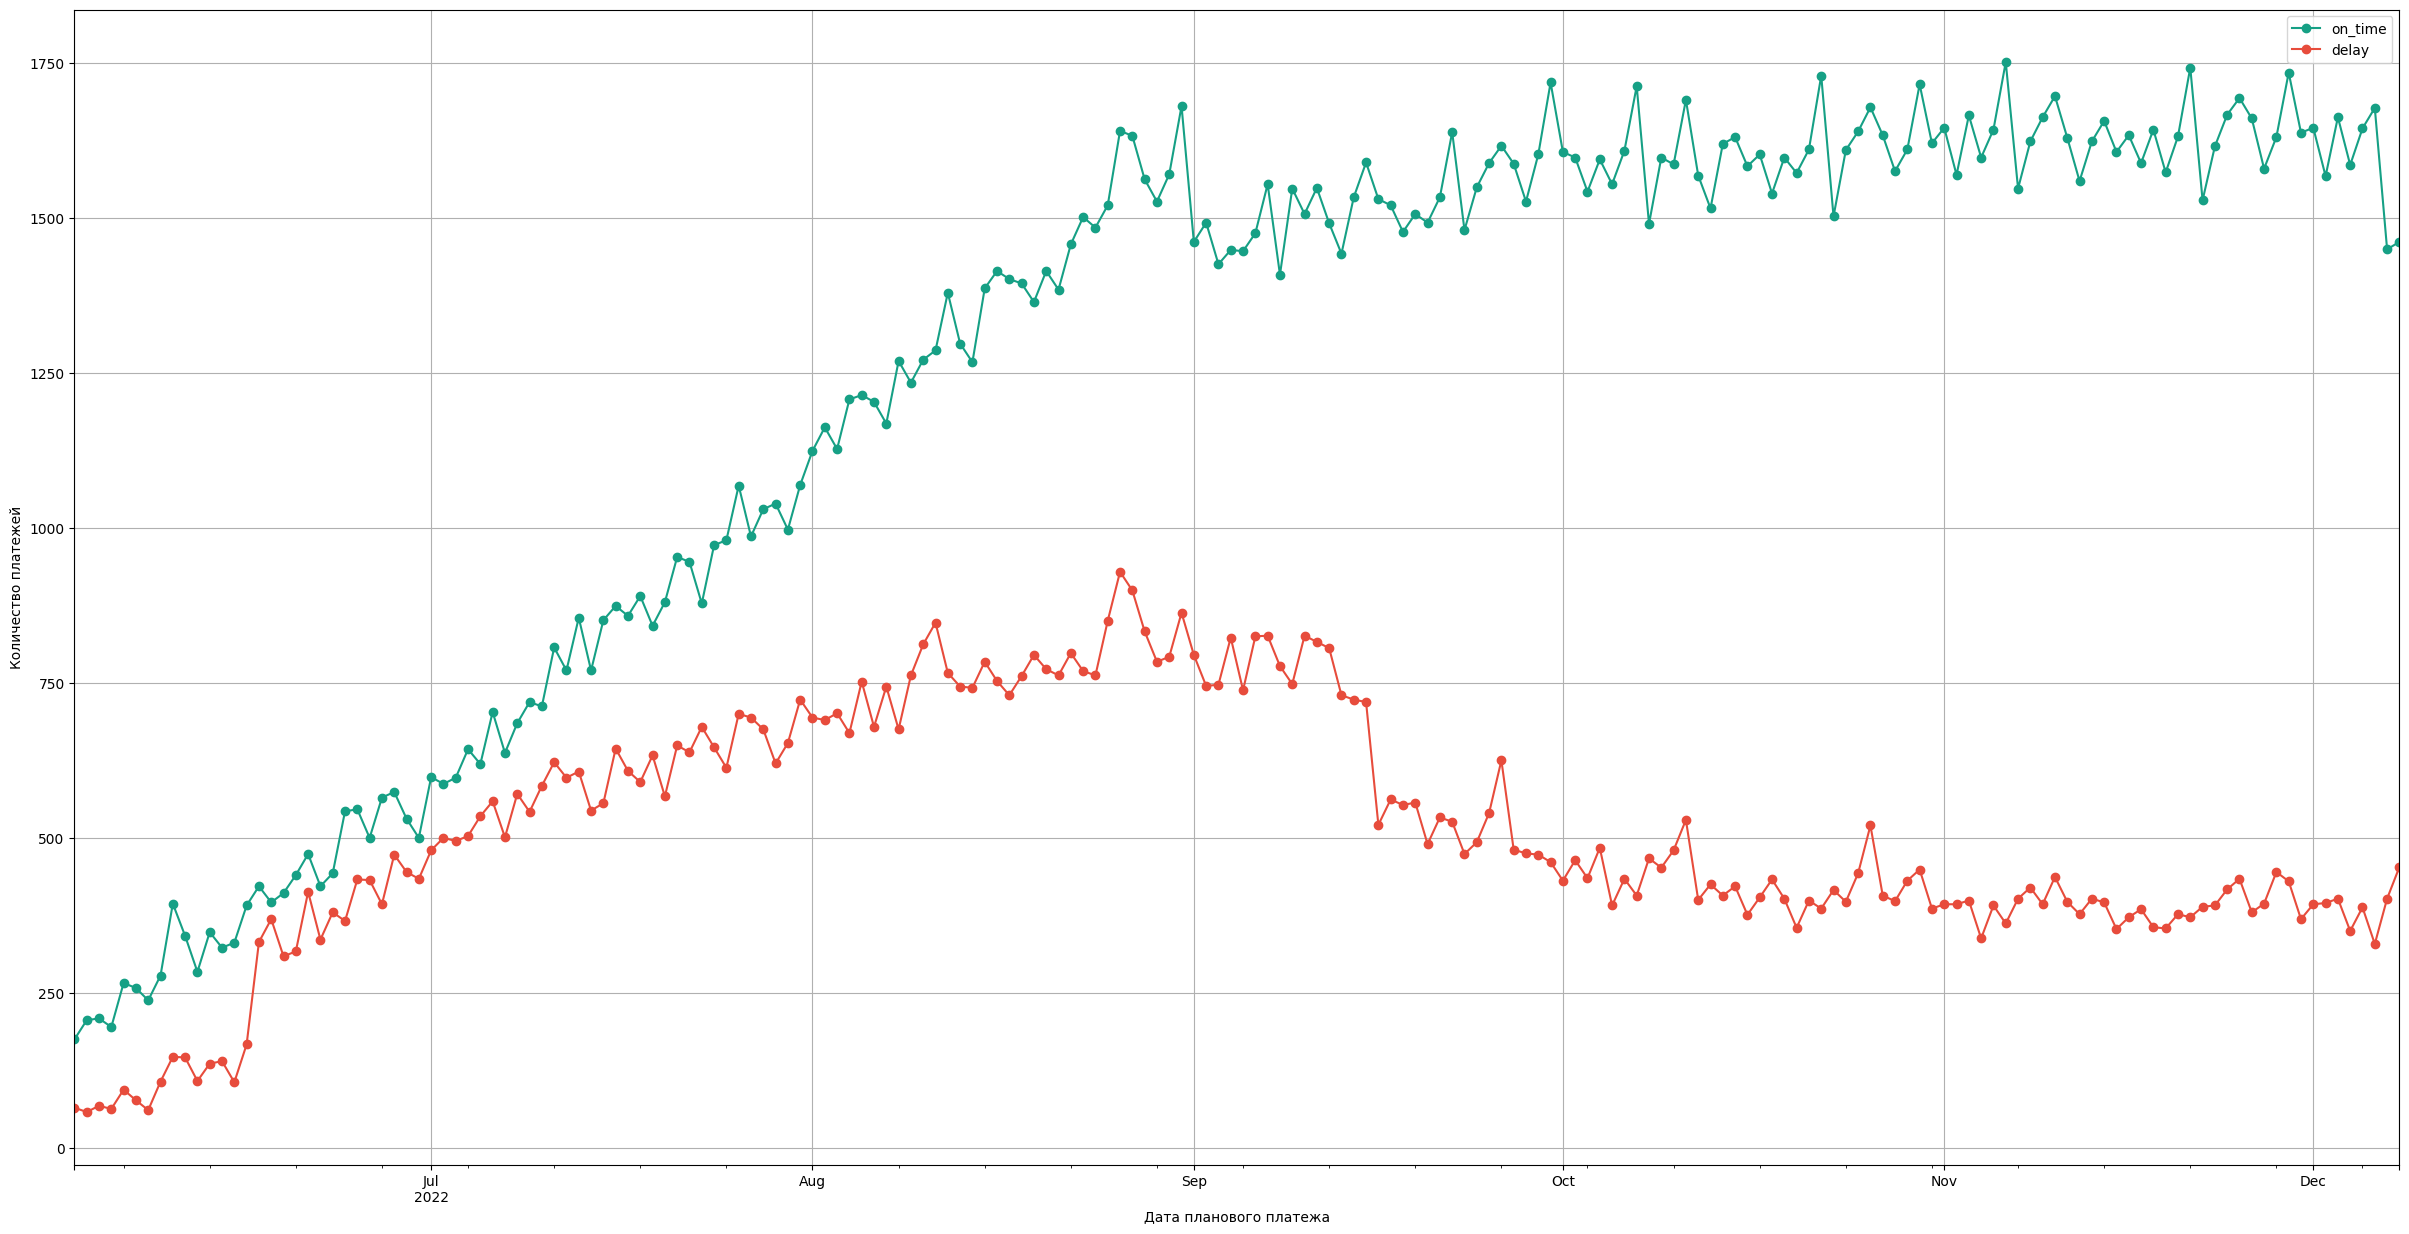

In [ ]:
#Cтроим диаграмму
delay_pivot.plot(kind = 'line',
                           x = 'plan_at',
                           y = ['on_time','delay'],
                           ylabel = 'Количество платежей',
                           xlabel = 'Дата планового платежа',
                           legend = True,
                           grid = True,
                           figsize = (30,15),
                           marker = 'o',
                           color = ['#16a085' ,'#e74c3c']
                          )
plt.ticklabel_format(style = 'plain', axis = 'y')

<font color='#777778'>Начиная с июня 2022 года по сентябрь 2022 года наблюдается тенденция к общему увеличению платежей. При этом разрыв между просроченным платежами и платежами сделанными вовремя - незначительный.

<font color='#777778'>Стоит отметить, что количество платежей сделанных вовремя превышает количество просроченных платежей на протяжении всего наблюдаемого периода;

<font color='#777778'>По мере увеличения общего количества запланированных оплат, растёт также разрыв между количеством сделанных вовремя и просроченных платежей. На основании наблюдаемых данных можно предположить, что большое количество займов гасится досрочно.

<font color='#777778'> До сентября 2022 года наблюдается рост количества просроченных платежей, а начиная с сентября и до декабря количество просроченных платежей уменьшается.

### Динамика по количеству закрытых с опозданием займов

<font color='#777778'> Для оценки динамики по займам, закрытым вовремя или с опозданием построим столбчатую диаграмму по месяцам. В первом столбце покажем количество закрытых заранее или вовремя займов `on_time`, а во втором столбце просроченных - `delayed`.

In [ ]:
#Группируем данные для построения диаграммы
merged_df_2['closed_at'] = merged_df_2['closed_at'].dt.month

delay_pivot_2 = merged_df_2.pivot_table( index='closed_at',
                                         columns = 'closed_late',
                                         values = 'order_id',
                                         aggfunc= 'count').reset_index().rename_axis(None, axis=1)

delay_pivot_2 = delay_pivot_2.rename(columns = { 0: 'on_time', 1 : 'delay'})

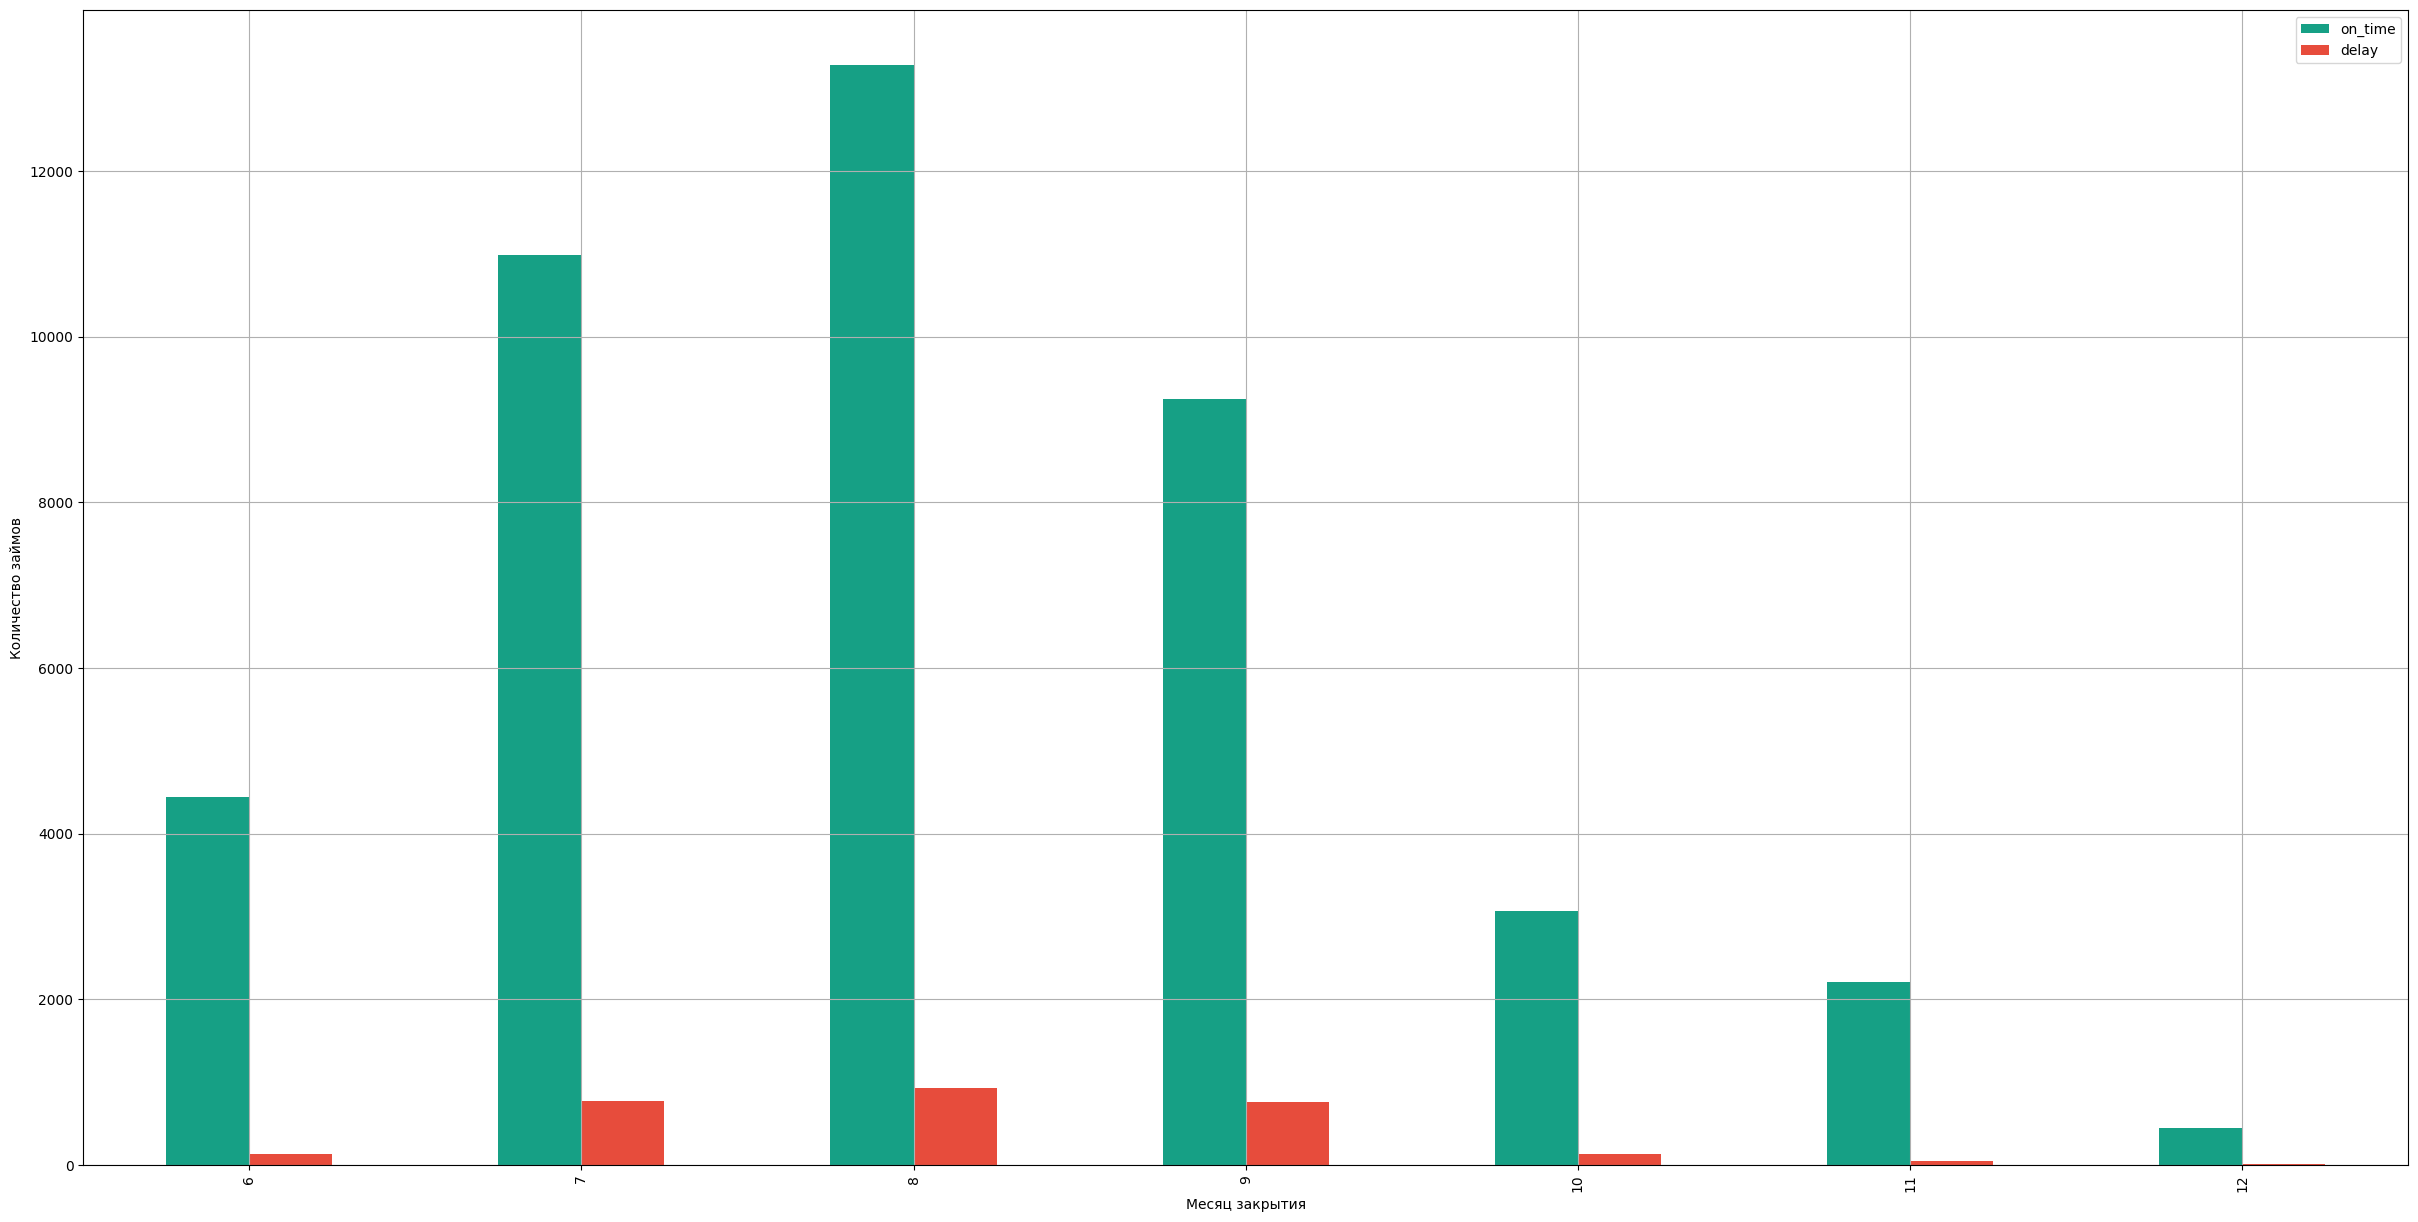

In [ ]:
#Cтроим диаграмму
delay_pivot_2.plot(kind = 'bar',
                           x = 'closed_at',
                           y = ['on_time','delay'],
                           ylabel = 'Количество займов',
                           xlabel = 'Месяц закрытия',
                           legend = True,
                           grid = True,
                           figsize = (30,15),
                           color = ['#16a085' ,'#e74c3c']
                          )
plt.ticklabel_format(style = 'plain', axis = 'y')

<font color='#777778'>Существует тенденция к увеличению количества займов закрытых с опозданием, начиная июня по август. При этом наблюдается общий рост количества закрытых займов.

<font color='#777778'>Несмотря на увеличение количества кредитов, закрытых с опозданием, количество кредитов закрытых вовремя также существенно выросло.

<font color='#777778'> Глядя на данные, можно предположить, что на общее количество закрытых займов влияет сезонность. Больше всего займов закрывается в середине года, а ближе к концу года количество закрытых займов снижается.

### Вывод по аналитическим задачам

<font color='#777778'>В результате анализа данных по кредитам за период с июня 2022 по декабрь 2022 было выявлено следующее:

- Начиная с июня 2022 года по сентябрь 2022 года наблюдается тенденция к общему увеличению количества платежей. При этом разрыв между просроченным платежами и платежами сделанными вовремя - незначительный;
- Стоит отметить, что количество платежей сделанных вовремя превышает количество просроченных платежей на протяжении всего наблюдаемого периода;
- По мере увеличения общего количества запланированных оплат, растёт также разрыв между количеством сделанных вовремя и просроченных платежей. На основании наблюдаемых данных можно предположить, что большое количество займов гасится досрочно;
- До сентября 2022 года наблюдается рост количества просроченных платежей, а начиная с сентября и до декабря количество просроченных платежей уменьшается;
- Существует тенденция к увеличению количества займов закрытых с опозданием, начиная июня по август. При этом наблюдается общий рост количества закрытых займов;
- Несмотря на увеличение количества кредитов, закрытых с опозданием, количество кредитов закрытых вовремя в наблюдаемый период также существенно выросло;
- Глядя на данные, можно предположить, что на общее количество закрытых займов влияет сезонность. Больше всего займов закрывается в середине года, а ближе к концу года количество закрытых займов снижается. </font>

## Итоговый вывод

<font color='#777778'> Предварительное знакомство с данными показало, что исходные датафреймы имеют достаточно высокое качество: в них практически отсутствуют полные дубликаты, написание наименований столбцов соответствует стилю snake_case.

<font color='#777778'> В датафрейме `orders` 16,64% пропущенных значений, однако пропуски в данном столбце скорее всего не случайны и сигнализируют о том, что заявка ещё не закрыта.

<font color='#777778'> В результате предобработки данных было выполнено следующее:

- Преобразованы типы данных в столбцах, содержащих информацию о датах из `object` в `float64`;
- Выполнено понижение разрядности в столбцах `order_id` во всех датафреймах и столбцах, содержащих денежные показатели;
- Датафрейм `payments` очищен от полных дубликатов;
- Подготовлено два датафрейма на решения аналитических задач: `merged_df` с детализацией по платежам и `merged_df_2` с детализацией по займам. </font>

<font color='#777778'>В результате анализа данных по кредитам за период с июня 2022 по декабрь 2022 было выявлено следующее:

- Начиная с июня 2022 года по сентябрь 2022 года наблюдается тенденция к общему увеличению количества платежей. При этом разрыв между просроченным платежами и платежами сделанными вовремя - незначительный;
- Стоит отметить, что количество платежей сделанных вовремя превышает количество просроченных платежей на протяжении всего наблюдаемого периода;
- По мере увеличения общего количества запланированных оплат, растёт также разрыв между количеством сделанных вовремя и просроченных платежей. На основании наблюдаемых данных можно предположить, что большое количество займов гасится досрочно;
- До сентября 2022 года наблюдается рост количества просроченных платежей, а начиная с сентября и до декабря количество просроченных платежей уменьшается;
- Существует тенденция к увеличению количества займов закрытых с опозданием, начиная июня по август. При этом наблюдается общий рост количества закрытых займов;
- Несмотря на увеличение количества кредитов, закрытых с опозданием, количество кредитов закрытых вовремя в наблюдаемый период также существенно выросло;
- Глядя на данные, можно предположить, что на общее количество закрытых займов влияет сезонность. Больше всего займов закрывается в середине года, а ближе к концу года количество закрытых займов снижается. </font>